## Exercise 7: Deep Q-learning (DQN)

In this exercise, you will implement DQN by [Mnih et al.](https://arxiv.org/abs/1312.5602). DQN was the first algorithm that was able to play Atari games while only using images as an input, showing the potential of deep reinforcement learning.

<img src="img/space_invaders.png" alt="Drawing" style="width: 400px;"/>

### 7.1 Continuous State Spaces

In `exercise04` we looked at tabular Q-learning, which uses a distinct Q-value for each individual state. Unfortunately, often the number of possible states is too high. Thus, by using function approximation methods like neural networks we can learn a parameterized Q-value function that can be applied on the whole state.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Q(nn.Module):
    """ A Q-function network."""
    def __init__(self, state_dim, action_dim, hidden_dim=50):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.as_tensor(x).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

The above implementation uses pytorch which is a very successfull deep learning network. In this exercise sheet we only need the basics of pytorch, but if you are interested the official pytorch documentation has some nice 60min [tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

### 7.2 Experience Replay
While the agent navigates through the environment, we store the transitions that the agent experiences in a *replay buffer*. With this we can reuse older experience, making the method more sample efficient and break the temporal correlations of the transitions.

In [2]:
import gym
from collections import deque
import random
import numpy as np

env =  gym.make("MountainCar-v0")
rb = deque(maxlen=30)  # First in first out queue.

# For demonstration purposes we fill the replay buffer by choosing 100 random actions.
state = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # We choose a random action
    next_state, reward, done, _ = env.step(action)

    rb.append([state, action, next_state, reward, done])
    state = next_state

For training neural networks one typically uses a minibatch of the transitions saved in the replay buffer.

In [3]:
def sample_batch(replay_buffer, batch_size):
    return [torch.tensor(e, dtype=torch.float) for e in zip(*random.choices(replay_buffer, k=batch_size))]

In [4]:
sample_batch(rb, 5)  # Returns list with (state, action, next_state, reward, done)

[tensor([[-0.5122,  0.0090],
         [-0.4215,  0.0070],
         [-0.5033,  0.0090],
         [-0.4284,  0.0077],
         [-0.5635,  0.0092]]),
 tensor([1., 0., 2., 1., 0.]),
 tensor([[-0.5033,  0.0090],
         [-0.4163,  0.0052],
         [-0.4935,  0.0098],
         [-0.4215,  0.0070],
         [-0.5550,  0.0085]]),
 tensor([-1., -1., -1., -1., -1.]),
 tensor([0., 0., 0., 0., 0.])]

### 7.3 DQN

In this section, you will implement DQN as described in lecture 10. The `Task` is to fill the missing main DQN implementation.

In [12]:
from collections import namedtuple

import torch.optim as optim
from tqdm import trange


EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self, env, gamma, lr=0.001, maxlen=100000):
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        self.env = env
        self._q = Q(state_dim, action_dim)
        self._q_target = Q(state_dim, action_dim)

        self._gamma = gamma
        self._q_optimizer = optim.Adam(self._q.parameters(), lr=lr)
        self._action_dim = action_dim

        self._replay_buffer = deque(maxlen=maxlen)

    def get_action(self, x, epsilon):
        if np.random.uniform() < epsilon:
            return np.random.randint(self._action_dim)

        return self._q(x).argmax().item()

    def train(self, episodes, time_steps, epsilon, update_freq=5):
        stats = EpisodeStats(episode_lengths=np.zeros(episodes), episode_rewards=np.zeros(episodes))

        episode_range = trange(episodes)
        for e in episode_range:
            s = self.env.reset()
            for t in range(time_steps):
                a = self.get_action(s, epsilon)
                ns, r, d, _ = self.env.step(a)

                stats.episode_rewards[e] += r
                stats.episode_lengths[e] = t
                
                # TODO: TASK - Implement

                # TASK 1: Add the samples to the replay buffer. Look at the code from above!
                self._replay_buffer.append([s, a, ns, r, d])
                
                # We sample a transition batch.
                batch_states, batch_actions, batch_next_states, batch_rewards, batch_terminal_flags = sample_batch(self._replay_buffer, 64)

                # TASK 2: Calculate the temporal difference target.
                target = batch_rewards + (1 - batch_terminal_flags) * self._gamma * torch.max(self._q_target(batch_next_states), dim=1)[0]

                
                current_prediction = self._q(batch_states)[torch.arange(64).long(), batch_actions.long()]
                loss = torch.mean((current_prediction - target.detach())**2)

                self._q_optimizer.zero_grad()  # Delete the outdated gradients.
                loss.backward()
                self._q_optimizer.step()

                if t % update_freq == 0:
                    self._q_target.load_state_dict(self._q.state_dict())
                    
                if d:
                    break

                s = ns
            episode_range.set_description(f"Episode Reward {stats.episode_rewards[e]} ")

        return stats

#### 7.3.1 Cart-Pole

We can start with the learning :). If the implementation is correct, you should achieve an episode reward of $200$ in the first $250$ episodes.

In [13]:
env = gym.make("CartPole-v0")
dqn = DQNAgent(env, gamma=0.99)

stats = dqn.train(episodes=250,
                  time_steps=200,
                  epsilon=0.1)

Episode Reward 200.0 : 100%|██████████| 250/250 [01:37<00:00,  2.56it/s]


**An example rollout**:

In [25]:
from visualization import rendered_rollout

rendered_rollout(env, dqn, max_steps=200)

Note, that in this version of cart-pole the episode ends after $200$ steps. Thus the agent does not care whether the pole crashes after the $200$ steps.

**Visualization of the episode stats:**

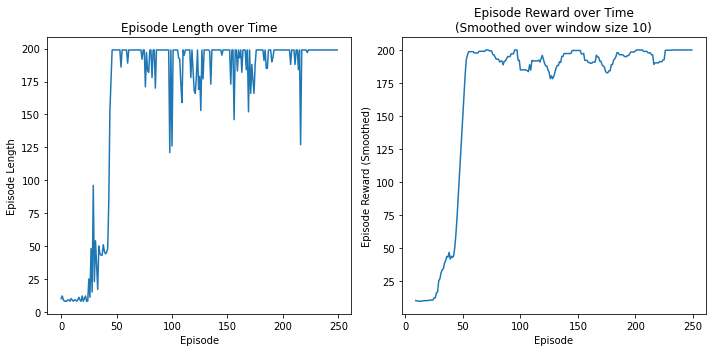

In [15]:
from visualization import plot_episode_stats

plot_episode_stats(stats)

#### 7.3.2 MountainCar

Another popular classical control environment is mountain car. Depending on your computer this might take a while.

In [16]:
env_m =  gym.make("MountainCar-v0")
dqn_m = DQNAgent(env_m, gamma=0.99)

stats_m = dqn_m.train(episodes=1000,
                      time_steps=200,
                      epsilon=0.2)

Episode Reward -127.0 : 100%|██████████| 1000/1000 [06:12<00:00,  2.68it/s]


**An example rollout**:

In [24]:
rendered_rollout(env_m, dqn_m, max_steps=200)

**Visualization of the episode stats:**

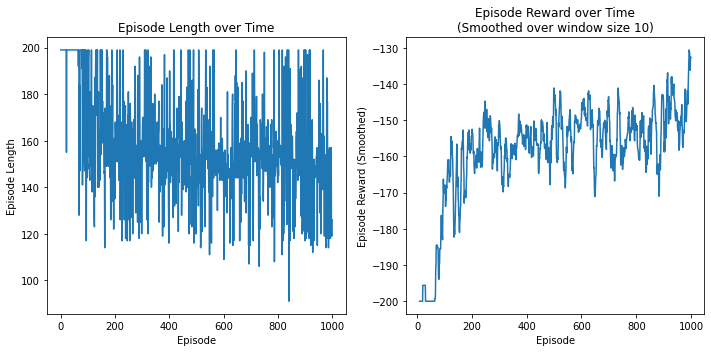

In [18]:
plot_episode_stats(stats_m)